In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from H1Inpainting import H1Inpainting
from L2ParabolicInpainting import L2ParabolicInpainting
from LpAdjointMask import LpAdjointMask
from H1Mask import H1Mask
from FSHalftoning import FSHalftoning
from Thresholding import Thresholding
from Utils import Utils

# Parabolic Inpainting

In [2]:
def l2ParabolicInpainting(f, w, h, dt, mask, errorFunction):
    inpainting = L2ParabolicInpainting(w, h)
    inpainting.setAlpha(dt)
    # Loop init
    x = np.multiply(f, mask)
    error = errorFunction(x, f, w, h)
    # Loop
    i = 0
    while True:
        i = i + 1
        xPrev = x
        errorPrev = error

        inpainting.setPrevious(xPrev)
        inpainting.assemble(f, mask)
        x = inpainting.process()

        error = errorFunction(x, f, w, h)

        if error >= errorPrev:
          break

    print("INPAINTING: N="+str(i-1)+" (t="+str((i-1)*dt)+")")

    return xPrev

# H1 Method

In [3]:
def h1Method(f, c, halftoningMethod):
    # Create Inpainting Mask
    maskGenerator = H1Mask(w,h)
    maskGenerator.setHalftoneMethod(halftoningMethod)
    mask, f = maskGenerator.create(f, c)

    # Solve the Inpainting problem
    InpaintingMethod = H1Inpainting(w,h)
    InpaintingMethod.assemble(f, mask)
    x = InpaintingMethod.process()

    return mask, x 

In [ ]:
c = 0.1

# Open image
fOriginal, w, h = Utils.openGrayscaleImage("./Trui.png")
f = Utils.applySPNoise(fOriginal, w, h, 0.01, 0.01, seed=0)

plt.imshow(f.reshape([h,w]), cmap='gray', vmin=0, vmax=1)
plt.show()

mask, x = h1Method(f, c, FSHalftoning(w,h))

plt.imshow(mask.reshape([h,w]), cmap='gray')
plt.show()

plt.imshow(x.reshape([h,w]), cmap='gray', vmin=0, vmax=1)
plt.show()

print(" L1-error(u,f)="+str(Utils.L1Error(fOriginal,x,w,h))+" L1-error(u,fn)="+str(Utils.L1Error(f,x,w,h)))

# L1-ADJ Method

In [4]:
def l1AdjMethod(f, c, alpha, halftoningMethod):
    # Create Inpainting Mask
    maskGenerator = LpAdjointMask(w,h)
    maskGenerator.setAlpha(alpha)
    maskGenerator.setP(1)
    maskGenerator.setHalftoneMethod(halftoningMethod)
    mask, f = maskGenerator.create(f, c)

    # Solve the Inpainting problem
    
    # For faster inpainting:
    # InpaintingMethod = H1Inpainting(w,h)
    # InpaintingMethod.assemble(f, mask)
    # x = InpaintingMethod.process()
    
    x = l2ParabolicInpainting(f, w, h, 10, mask, Utils.L1Error)

    return mask, x 

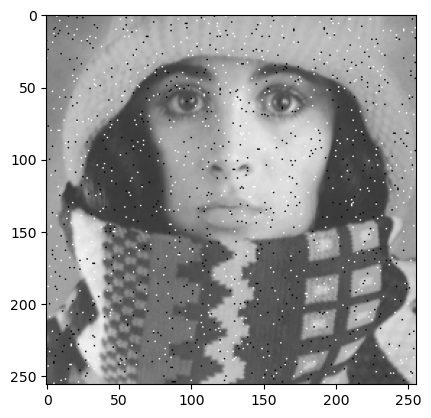

INPAINTING: N=15 (t=150)


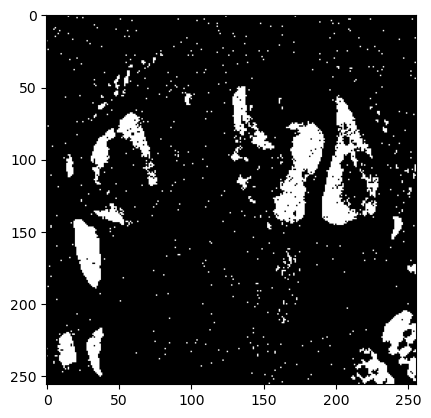

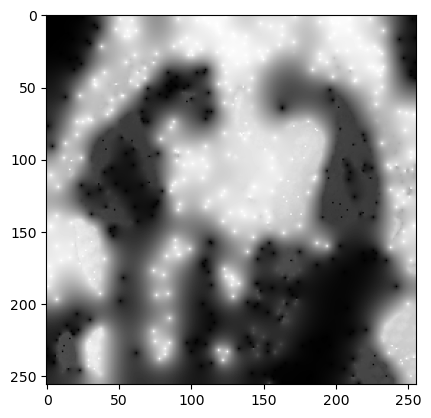

alpha=100 L1-error(u,f)=10995.911586322432 L1-error(u,fn)=11236.792157485981


In [9]:
# alpha = 0.01
# alpha = 0.79
alpha = 100
c = 0.1

# Open image
fOriginal, w, h = Utils.openGrayscaleImage("./Trui.png")
f = Utils.applySPNoise(fOriginal, w, h, 0.01, 0.01, seed=0)

plt.imshow(f.reshape([h,w]), cmap='gray', vmin=0, vmax=1)
plt.show()

mask, x = l1AdjMethod(f, c, alpha, Thresholding(w,h))

plt.imshow(mask.reshape([h,w]), cmap='gray')
plt.show()

plt.imshow(x.reshape([h,w]), cmap='gray', vmin=0, vmax=1)
plt.show()

print("alpha="+str(alpha)+" L1-error(u,f)="+str(Utils.L1Error(fOriginal,x,w,h))+" L1-error(u,fn)="+str(Utils.L1Error(f,x,w,h)))

## Parameter selection

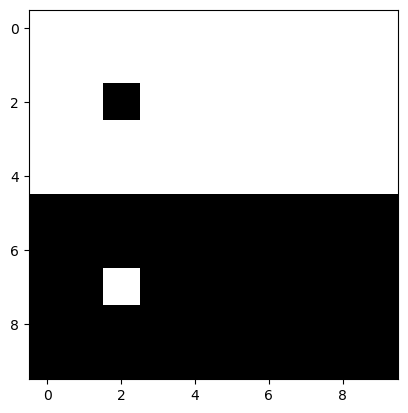

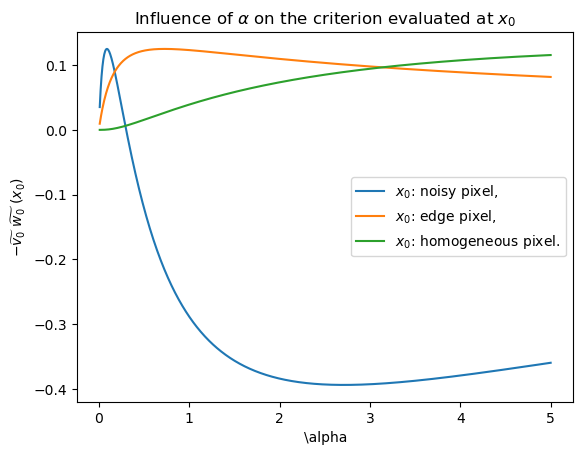

In [38]:
from Laplacian import Laplacian
from L2ParabolicInpainting import L2ParabolicInpainting

w = 10
h = w

c = 0.20

# Open image
fOriginal = 0*np.ones(w*h)
for i in range(0,int(h/2)):
    for j in range(0,w):
        fOriginal[i*w+j] = 1
f = fOriginal
f[22] = 0
f[72] = 1

plt.imshow(f.reshape([h,w]), cmap='gray', vmin=0, vmax=1)
plt.show()
Utils.saveGrayscaleImage(f, w, h, "results/crit-value-test.png")

p_noisy = []
p_edge = []
p_homo = []
alphas = np.linspace(0.01, 5, 1000)
for alpha in alphas:    
    p = 1
    LF = Laplacian(w,h)
    lapF = LF.assemble().process(f)
    
    # plt.imshow(lapF.reshape([h,w]))
    # plt.title(r"$\Delta f_\delta$")
    # plt.colorbar()
    # plt.show()
    
    IM = L2ParabolicInpainting(w,h)
    IM.setAlpha(alpha)
    IM.setPrevious(alpha*lapF)
    IM.assemble(0*np.ones(w*h), np.zeros(w*h))
    v0 = IM.process()
    
    # plt.imshow(v0.reshape([h,w]))
    # plt.title(r"$\widetilde{v_0}$")
    # plt.colorbar()
    # plt.show()
    
    IM = L2ParabolicInpainting(w,h)
    IM.setAlpha(alpha)
    # IM.setPrevious( -np.power(abs(v0), p-2)*v0)
    IM.setPrevious( -np.sign(v0))
    IM.assemble(0*np.ones(w*h), np.zeros(w*h))
    w0 = IM.process()
    
    # plt.imshow(w0.reshape([h,w]))
    # plt.title(r"$\widetilde{w_0}$")
    # plt.colorbar()
    # plt.show()
    
    criterion = -v0*w0
    
    # plt.imshow(criterion.reshape([h,w]))
    # plt.title(r"$-\widetilde{v_0}\widetilde{w_0}$")
    # plt.colorbar()
    # plt.show()
    
    p_noisy.append(criterion[22])
    p_edge.append(criterion[44])
    p_homo.append(criterion[76])
    ######
        


plt.plot(alphas, p_noisy, label=r"$x_0$: noisy pixel,")
plt.plot(alphas, p_edge, label=r"$x_0$: edge pixel,")
plt.plot(alphas, p_homo, label=r"$x_0$: homogeneous pixel.")
plt.xlabel(r"\alpha")
plt.ylabel(r"$-\widetilde{v_0}\ \widetilde{w_0}\ (x_0)$")
plt.title(r"Influence of $\alpha$ on the criterion evaluated at $x_0$")
plt.legend()
plt.show()



# L2-ADJ Method

In [39]:
def l2AdjMethod(f, c, alpha, halftoningMethod):
    # Create Inpainting Mask
    maskGenerator = LpAdjointMask(w,h)
    maskGenerator.setAlpha(alpha)
    maskGenerator.setP(2)
    maskGenerator.setHalftoneMethod(halftoningMethod)
    mask, f = maskGenerator.create(f, c)

    # Solve the Inpainting problem
    
    # For faster inpainting:
    # InpaintingMethod = H1Inpainting(w,h)
    # InpaintingMethod.assemble(f, mask)
    # x = InpaintingMethod.process()
    
    x = l2ParabolicInpainting(f, w, h, 10, mask, Utils.L2Error)

    return mask, x 

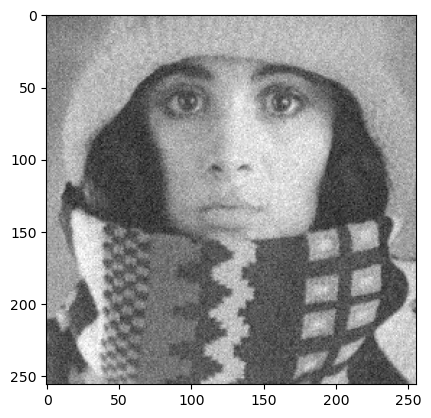

INPAINTING: N=53 (t=530)


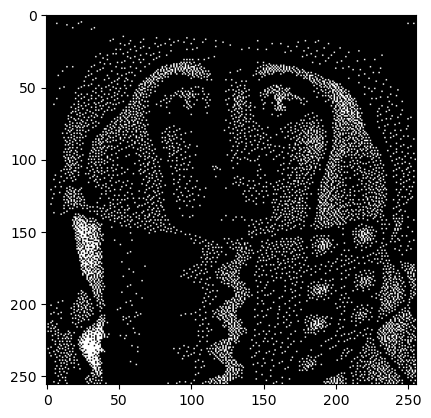

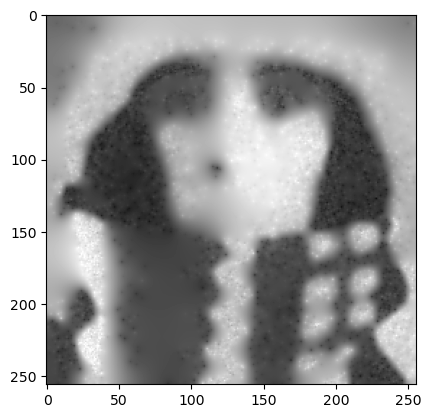

alpha=100 L2-error(u,f)=23.738068062210356 L2-error(u,fn)=26.40417132166682


In [42]:
alpha = 100
c = 0.1

# Open image
fOriginal, w, h = Utils.openGrayscaleImage("./Trui.png")
f = Utils.applyWhiteNoise(fOriginal, w, h, 0.05, seed=0)

plt.imshow(f.reshape([h,w]), cmap='gray', vmin=0, vmax=1)
plt.show()

mask, x = l2AdjMethod(f, c, alpha, FSHalftoning(w,h))

plt.imshow(mask.reshape([h,w]), cmap='gray')
plt.show()

plt.imshow(x.reshape([h,w]), cmap='gray', vmin=0, vmax=1)
plt.show()

print("alpha="+str(alpha)+" L2-error(u,f)="+str(Utils.L2Error(fOriginal,x,w,h))+" L2-error(u,fn)="+str(Utils.L2Error(f,x,w,h)))

## Parameter selection

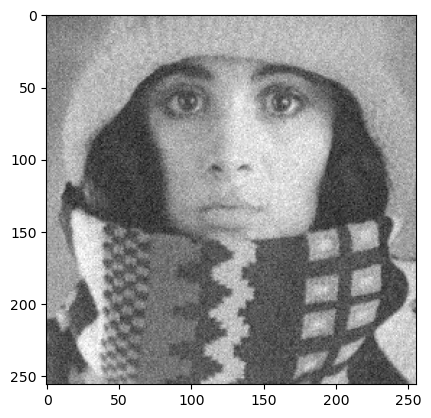

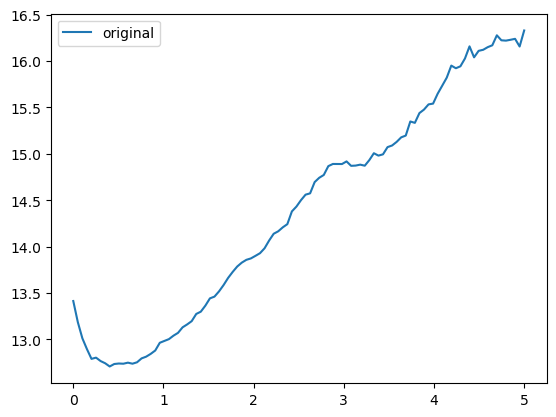

In [42]:
from Laplacian import Laplacian
from L2ParabolicInpainting import L2ParabolicInpainting

w = 10
h = w

c = 0.20
deviation = 0.05

# Open image
# fOriginal = 0*np.ones(w*h)
# for i in range(0,int(h/2)):
#     for j in range(0,w):
#         fOriginal[i*w+j] = 1
# f = fOriginal + np.random.normal(loc=0.0, scale=deviation, size=w*h)
fOriginal, w, h = Utils.openGrayscaleImage("./Trui.png")
f = Utils.applyWhiteNoise(fOriginal, w, h, deviation, seed=0)

plt.imshow(f.reshape([h,w]), cmap='gray', vmin=0, vmax=1)
plt.show()

# alpha = 0.1
# alpha = 0.176
# alpha = 0.1
# alpha = 2
# alpha = 6

l2 = []
l2_noise = []
alphas = np.linspace(0.00001, 5, 100)
for alpha in alphas:    
    p = 2
    LF = Laplacian(w,h)
    lapF = LF.assemble().process(f)
    
    # plt.imshow(lapF.reshape([h,w]))
    # plt.title(r"$\Delta f_\delta$")
    # plt.colorbar()
    # plt.show()
    
    IM = L2ParabolicInpainting(w,h)
    IM.setAlpha(alpha)
    IM.setPrevious(alpha*lapF)
    IM.assemble(0*np.ones(w*h), np.zeros(w*h))
    v0 = IM.process()
    
    # plt.imshow(v0.reshape([h,w]))
    # plt.title(r"$\widetilde{v_0}$")
    # plt.colorbar()
    # plt.show()
    
    IM = L2ParabolicInpainting(w,h)
    IM.setAlpha(alpha)
    IM.setPrevious( -np.power(abs(v0), p-2)*v0)
    IM.assemble(0*np.ones(w*h), np.zeros(w*h))
    w0 = IM.process()
    
    # plt.imshow(w0.reshape([h,w]))
    # plt.title(r"$\widetilde{w_0}$")
    # plt.colorbar()
    # plt.show()
    
    criterion = -v0*w0
    
    # plt.imshow(criterion.reshape([h,w]))
    # plt.title(r"$-\widetilde{v_0}\widetilde{w_0}$")
    # plt.colorbar()
    # plt.show()
    
    mask = Thresholding(w,h).process(criterion, c)
    ######
    
    InpaintingMethod = H1Inpainting(w,h)
    InpaintingMethod.assemble(f, mask)
    x = InpaintingMethod.process()
    
    # plt.imshow(mask.reshape([h,w]), cmap='gray')
    # plt.show()
    
    # plt.imshow(x.reshape([h,w]), cmap='gray', vmin=0, vmax=1)
    # plt.show()
    
    # print("alpha="+str(alpha)+" L2-error(u,f)="+str(Utils.L2Error(fOriginal,x,w,h))+" L2-error(u,fn)="+str(Utils.L2Error(f,x,w,h)))
    l2.append(Utils.L2Error(fOriginal,x,w,h))
    l2_noise.append(Utils.L2Error(f,x,w,h))

plt.plot(alphas, l2, label="original")
# plt.plot(alphas, l2_noise, label="noise")
plt.legend()
plt.show()

# Numerical Results

## Salt and Pepper Noise

In [11]:
import csv

compressions = [0.05, 0.1, 0.15]
noiseLevels = [ [0,0], [0.02,0], [0,0.02], [0.01,0.01], [0.04,0], [0,0.04], [0.02,0.02], [0.1,0], [0,0.1], [0.05,0.05] ]
alphasL1ADJT = [ [0.01, 2.67, 1.47, 0.46, 2.67, 1.61, 0.41, 3.02, 5.38, 0.36],
                 [0.01, 0.41, 0.36, 0.56, 0.36, 2.07, 0.46, 0.26, 2.42, 0.36],
                 [0.01, 0.46, 0.41, 0.61, 0.41, 0.36, 0.51, 0.31, 0.36, 0.41]]
alphasL1ADJH = [ [3.62, 1.01, 0.96, 0.78, 0.56, 1.72, 0.71, 0.56, 0.56, 0.41],
                 [2.27, 0.66, 0.71, 0.76, 0.56, 0.56, 0.61, 0.51, 0.51, 0.51],
                 [1.16, 0.61, 0.71, 0.61, 0.61, 0.71, 0.56, 0.56, 0.51, 0.51]]

In [14]:
!rm -Rf results
!mkdir results

# Open images
fOriginal, w, h = Utils.openGrayscaleImage("./Trui.png")

for n in range(0,len(compressions)):
    c = compressions[n]
    !mkdir results/{c}
    print("Compression: "+str(c))
    with open("results/"+str(c)+"/errors.csv", mode='w') as errors_file:
        errors_writer = csv.writer(errors_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_NONE)
        errors_writer.writerow(['salt', 'pepper', 'alphaL1T', "errorL1T", "alphaL1H", "errorL1H", "errorH1T", "errorH1H"])
        errors_file.flush()
        for i in range(0,len(noiseLevels)):
            noiseLevel  = noiseLevels[i]
            print("  Noise: "+str(noiseLevel))
            
            alphaL1ADJT = alphasL1ADJT[n][i]
            alphaL1ADJH = alphasL1ADJH[n][i]
        
            # Apply noise    
            f = Utils.applySPNoise(fOriginal, w, h, noiseLevel[0], noiseLevel[1], seed=0)
            Utils.saveGrayscaleImage(f, w, h, "results/"+str(c)+"/Trui-sp-"+str(noiseLevel[0])+"-"+str(noiseLevel[1])+".png")
            
            # L1-ADJ-T
            maskL1AdjT, xL1AdjT = l1AdjMethod(f, c, alphaL1ADJT, Thresholding(w,h))
            errorOriginalL1AdjT = Utils.L1Error(fOriginal, xL1AdjT, w, h)
            errorL1AdjT = Utils.L1Error(f, xL1AdjT, w, h)
            print("    L1-ADJ-T: alpha="+str(alphaL1ADJT)+" L1-error(u,f)="+str(errorOriginalL1AdjT)+" L1-error(u,fn)="+str(errorL1AdjT))
            Utils.saveGrayscaleImage(maskL1AdjT, w, h, "results/"+str(c)+"/mask-L1-T-sp-"+str(noiseLevel[0])+"-"+str(noiseLevel[1])+".png")
            Utils.saveGrayscaleImage(xL1AdjT, w, h, "results/"+str(c)+"/decoded-L1-T-sp-"+str(noiseLevel[0])+"-"+str(noiseLevel[1])+".png")
            # L1-ADJ-H
            maskL1AdjH, xL1AdjH = l1AdjMethod(f, c, alphaL1ADJH, FSHalftoning(w,h))
            errorOriginalL1AdjH = Utils.L1Error(fOriginal, xL1AdjH, w, h)
            errorL1AdjH = Utils.L1Error(f, xL1AdjH, w, h)
            print("    L1-ADJ-H: alpha="+str(alphaL1ADJH)+" L1-error(u,f)="+str(errorOriginalL1AdjH)+" L1-error(u,fn)="+str(errorL1AdjH))
            Utils.saveGrayscaleImage(maskL1AdjH, w, h, "results/"+str(c)+"/mask-L1-H-sp-"+str(noiseLevel[0])+"-"+str(noiseLevel[1])+".png")
            Utils.saveGrayscaleImage(xL1AdjH, w, h, "results/"+str(c)+"/decoded-L1-H-sp-"+str(noiseLevel[0])+"-"+str(noiseLevel[1])+".png")
            # H1-T
            maskH1T, xH1T = h1Method(f, c, Thresholding(w,h))
            errorOriginalH1T = Utils.L1Error(fOriginal, xH1T, w, h)
            errorH1T = Utils.L1Error(f, xH1T, w, h)
            print("    H1-T: L1-error(u,f)="+str(errorOriginalH1T)+" L1-error(u,fn)="+str(errorH1T))
            Utils.saveGrayscaleImage(maskH1T, w, h, "results/"+str(c)+"/mask-H1-T-sp-"+str(noiseLevel[0])+"-"+str(noiseLevel[1])+".png")
            Utils.saveGrayscaleImage(xH1T, w, h, "results/"+str(c)+"/decoded-H1-T-sp-"+str(noiseLevel[0])+"-"+str(noiseLevel[1])+".png")
            # H1-H
            maskH1H, xH1H = h1Method(f, c, FSHalftoning(w,h))
            errorOriginalH1H = Utils.L1Error(fOriginal, xH1H, w, h)
            errorH1H = Utils.L1Error(f, xH1H, w, h)
            print("    H1-H: L1-error(u,f)="+str(errorOriginalH1H)+" L1-error(u,fn)="+str(errorH1H))
            Utils.saveGrayscaleImage(maskH1H, w, h, "results/"+str(c)+"/mask-H1-H-sp-"+str(noiseLevel[0])+"-"+str(noiseLevel[1])+".png")
            Utils.saveGrayscaleImage(xH1H, w, h, "results/"+str(c)+"/decoded-H1-H-sp-"+str(noiseLevel[0])+"-"+str(noiseLevel[1])+".png")

            # write errors
            errors_writer.writerow([noiseLevel[0], noiseLevel[1], alphaL1ADJT, errorOriginalL1AdjT, alphaL1ADJH, errorOriginalL1AdjH, errorOriginalH1T, errorOriginalH1H])
            errors_file.flush()
        errors_file.close()

!zip -r results-sp.zip results/

Compression: 0.05
  Noise: [0, 0]
INPAINTING: N=3756 (t=37560)
    L1-ADJ-T: alpha=0.01 L1-error(u,f)=7231.192169761404 L1-error(u,fn)=7230.741189369247
INPAINTING: N=149 (t=1490)
    L1-ADJ-H: alpha=3.62 L1-error(u,f)=1635.9709076588094 L1-error(u,fn)=1636.4218880509663
    H1-T: L1-error(u,f)=8100.572734867228 L1-error(u,fn)=8100.121754475071
    H1-H: L1-error(u,f)=1961.3938075242925 L1-error(u,fn)=1960.9428271321356
  Noise: [0.02, 0]
INPAINTING: N=317 (t=3170)
    L1-ADJ-T: alpha=2.67 L1-error(u,f)=4370.07124051612 L1-error(u,fn)=4792.825407816526
INPAINTING: N=61 (t=610)
    L1-ADJ-H: alpha=1.01 L1-error(u,f)=1962.4915542397493 L1-error(u,fn)=2469.818193993998
    H1-T: L1-error(u,f)=13128.154343174858 L1-error(u,fn)=12508.883754939565
    H1-H: L1-error(u,f)=11086.307476053711 L1-error(u,fn)=10479.272816083932
  Noise: [0, 0.02]
INPAINTING: N=36 (t=360)
    L1-ADJ-T: alpha=1.47 L1-error(u,f)=3885.8351630946154 L1-error(u,fn)=4434.911826966711
INPAINTING: N=16 (t=160)
    L1-ADJ-

## Gaussian Noise

In [ ]:
import csv

compressions = [0.05, 0.1, 0.15]
noiseLevels = [ 0, 0.03, 0.05, 0.1, 0.2 ]
alphasL2ADJT = [ [0.01, 0.31, 0.66, 1.16, 0.01],
                 [0.01, 0.71, 0.86, 0.71, 0.01],
                 [0.01, 0.71, 0.51, 0.31, 0.01]]
alphasL2ADJH = [ [2.62, 1.37, 2.07, 1.81, 0.01],
                 [0.01, 0.96, 0.76, 0.66, 2.27],
                 [0.01, 0.56, 0.66, 0.76, 1.11]]

In [ ]:
!rm -Rf results
!mkdir results

# Open images
fOriginal, w, h = Utils.openGrayscaleImage("./Trui.png")

for n in range(0,len(compressions)):
    c = compressions[n]
    !mkdir results/{c}
    print("Compression: "+str(c))
    with open("results/"+str(c)+"/errors.csv", mode='w') as errors_file:
        errors_writer = csv.writer(errors_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_NONE)
        errors_writer.writerow(['deviation', 'alphaL2T', "errorL2T", "alphaL2H", "errorL2H", "errorH1T", "errorH1H"])
        errors_file.flush()
        for i in range(0,len(noiseLevels)):
            noiseLevel  = noiseLevels[i]
            print("  Noise: "+str(noiseLevel))
            
            alphaL2ADJT = alphasL2ADJT[n][i]
            alphaL2ADJH = alphasL2ADJH[n][i]
        
            # Apply noise    
            f = Utils.applyWhiteNoise(fOriginal, w, h, noiseLevel, seed=0)
            Utils.saveGrayscaleImage(f, w, h, "results/"+str(c)+"/Trui-wn-"+str(noiseLevel)+".png")
            
            # L2-ADJ-T
            maskL2AdjT, xL2AdjT = l2AdjMethod(f, c, alphaL2ADJT, Thresholding(w,h))
            errorOriginalL2AdjT = Utils.L2Error(fOriginal, xL2AdjT, w, h)
            errorL2AdjT = Utils.L2Error(f, xL2AdjT, w, h)
            print("    L2-ADJ-T: alpha="+str(alphaL2ADJT)+" L2-error(u,f)="+str(errorOriginalL2AdjT)+" L2-error(u,fn)="+str(errorL2AdjT))
            Utils.saveGrayscaleImage(maskL2AdjT, w, h, "results/"+str(c)+"/mask-L2-T-wn-"+str(noiseLevel)+".png")
            Utils.saveGrayscaleImage(xL2AdjT, w, h, "results/"+str(c)+"/decoded-L2-T-wn-"+str(noiseLevel)+".png")
            # L2-ADJ-H
            maskL2AdjH, xL2AdjH = l2AdjMethod(f, c, alphaL2ADJH, FSHalftoning(w,h))
            errorOriginalL2AdjH = Utils.L2Error(fOriginal, xL2AdjH, w, h)
            errorL2AdjH = Utils.L2Error(f, xL2AdjH, w, h)
            print("    L2-ADJ-H: alpha="+str(alphaL2ADJH)+" L2-error(u,f)="+str(errorOriginalL2AdjH)+" L2-error(u,fn)="+str(errorL2AdjH))
            Utils.saveGrayscaleImage(maskL2AdjH, w, h, "results/"+str(c)+"/mask-L2-H-wn-"+str(noiseLevel)+".png")
            Utils.saveGrayscaleImage(xL2AdjH, w, h, "results/"+str(c)+"/decoded-L2-H-wn-"+str(noiseLevel)+".png")
            # H1-T
            maskH1T, xH1T = h1Method(f, c, Thresholding(w,h))
            errorOriginalH1T = Utils.L2Error(fOriginal, xH1T, w, h)
            errorH1T = Utils.L2Error(f, xH1T, w, h)
            print("    H1-T: L2-error(u,f)="+str(errorOriginalH1T)+" L2-error(u,fn)="+str(errorH1T))
            Utils.saveGrayscaleImage(maskH1T, w, h, "results/"+str(c)+"/mask-H1-T-wn-"+str(noiseLevel)+".png")
            Utils.saveGrayscaleImage(xH1T, w, h, "results/"+str(c)+"/decoded-H1-T-wn-"+str(noiseLevel)+".png")
            # H1-H
            maskH1H, xH1H = h1Method(f, c, FSHalftoning(w,h))
            errorOriginalH1H = Utils.L2Error(fOriginal, xH1H, w, h)
            errorH1H = Utils.L2Error(f, xH1H, w, h)
            print("    H1-H: L2-error(u,f)="+str(errorOriginalH1H)+" L2-error(u,fn)="+str(errorH1H))
            Utils.saveGrayscaleImage(maskH1H, w, h, "results/"+str(c)+"/mask-H1-H-wn-"+str(noiseLevel)+".png")
            Utils.saveGrayscaleImage(xH1H, w, h, "results/"+str(c)+"/decoded-H1-H-wn-"+str(noiseLevel)+".png")

            # write errors
            errors_writer.writerow([noiseLevel, alphaL2ADJT, errorOriginalL2AdjT, alphaL2ADJH, errorOriginalL2AdjH, errorOriginalH1T, errorOriginalH1H])
            errors_file.flush()
        errors_file.close()

!zip -r results-wn.zip results/